In [31]:
### Step 1: Load the Global Power Plant Dataset

import pandas as pd  # Library to handle dataframes

# Load the CSV file safely (avoids dtype warnings using low_memory=False)
file_path = "global_power_plant_database.csv"  # Update path if needed
df = pd.read_csv(file_path, low_memory=False)

# Display the first 5 rows to understand structure
df.head()


,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.1190,Hydro,NaN,NaN,...,123.77,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.7950,Solar,NaN,NaN,...,18.43,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.7920,Solar,NaN,NaN,...,18.64,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.556,69.4787,Hydro,NaN,NaN,...,225.06,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.641,69.7170,Hydro,NaN,NaN,...,406.16,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


In [32]:
### Step 2: Filter dataset to include only rows where 2017 generation data is available

# We keep only those power plants that have a non-null value for estimated generation in 2017
df_filtered = df[df['estimated_generation_gwh_2017'].notnull()]

# Check how many rows are remaining after filtering
df_filtered.shape


(33138, 36)

In [44]:
### Step 3: Mark Plants with Policy Incentives (Solar/Wind)
df_filtered = df_filtered.copy()  # Prevent SettingWithCopyWarning

# Add a new binary column: 1 if the plant uses Solar or Wind, else 0
df_filtered['policy_incentive'] = df_filtered['primary_fuel'].apply(
    lambda x: 1 if x in ['Solar', 'Wind'] else 0
)


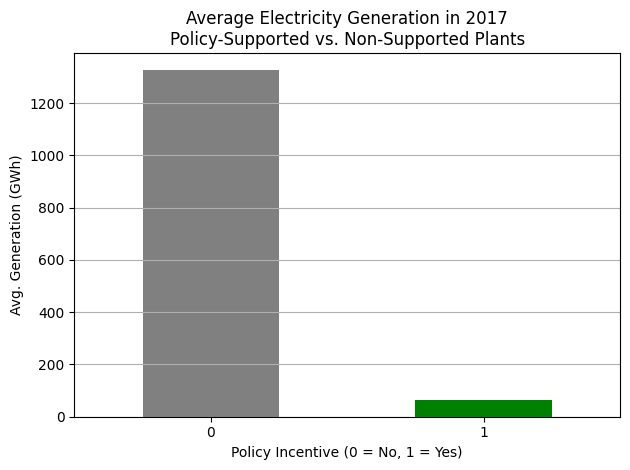

In [16]:
### Step 4: Visualize the Impact of Policy Incentives on Electricity Generation
import matplotlib.pyplot as plt  # For plotting

# Group by policy incentive and calculate average electricity generation for 2017
avg_generation = df_filtered.groupby('policy_incentive')['estimated_generation_gwh_2017'].mean()

# Step 4: Plot the comparison
avg_generation.plot(kind='bar', color=['gray', 'green'])

plt.title("Average Electricity Generation in 2017\nPolicy-Supported vs. Non-Supported Plants")
plt.ylabel("Avg. Generation (GWh)")
plt.xlabel("Policy Incentive (0 = No, 1 = Yes)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [6]:
### Step 6: Conclusion

conclusion = """
Conclusion:

From the above comparison, we can observe that power plants without policy incentives (like coal or hydro) 
have much higher average generation in 2017 compared to those with policy support (like solar or wind). 

This may be because non-supported plants are older, more established, and have higher capacity, 
while supported plants are relatively new and smaller in size.

This shows that while policy-supported plants are growing, they still need more time and capacity 
to match traditional sources.

Such analysis helps policymakers understand where support is needed to boost renewable energy output.
"""
print(conclusion)



Conclusion:

From the above comparison, we can observe that power plants without policy incentives (like coal or hydro) 
have much higher average generation in 2017 compared to those with policy support (like solar or wind). 

This may be because non-supported plants are older, more established, and have higher capacity, 
while supported plants are relatively new and smaller in size.

This shows that while policy-supported plants are growing, they still need more time and capacity 
to match traditional sources.

Such analysis helps policymakers understand where support is needed to boost renewable energy output.



In [34]:
### Step 6A: Import Libraries for DML

from econml.dml import LinearDML
from sklearn.ensemble import RandomForestClassifier  # Classifier for binary treatment
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [35]:
# Step 6B: Drop rows with missing values in outcome and control variable
df_dml = df_filtered.dropna(subset=['estimated_generation_gwh_2017', 'capacity_mw'])


In [36]:
### Step 6C: Define Y (Outcome), T (Treatment), X (Control)
# Define outcome (Y), treatment (T), and features (X)
Y = df_dml['estimated_generation_gwh_2017'].values      # Continuous outcome
T = df_dml['policy_incentive'].values                   # Binary treatment (0 or 1)
X = df_dml[['capacity_mw']].values                      # Control feature(s)

# Optional: Scale the control variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the shapes
print("Data ready for DoubleML:")
print(f"Y shape: {Y.shape}, T shape: {T.shape}, X shape: {X_scaled.shape}")


Data ready for DoubleML:
Y shape: (33138,), T shape: (33138,), X shape: (33138, 1)


In [37]:
# Step 6D: Fit the Double Machine Learning Model (LinearDML)
model_y = LassoCV()                         # For continuous outcome
model_t = RandomForestClassifier()          # Since treatment T is binary (0/1)

# Create the DML estimator
dml = LinearDML(model_y=model_y,
                model_t=model_t,
                discrete_treatment=True,
                random_state=42)

# Fit the DML estimator
dml.fit(Y, T, X=X_scaled)

# Estimate the Average Treatment Effect (ATE)
ate = dml.ate(X=X_scaled)

# Print the estimated ATE
print(f"Estimated Average Treatment Effect (ATE): {ate:.2f}")


Estimated Average Treatment Effect (ATE): -306.31


In [51]:
###Step 6E: DML Analysis Conclusion
dml_conclusion = """
Double Machine Learning (DML) Conclusion:

We applied the LinearDML method to estimate the "causal effect" of renewable energy policy incentives 
(e.g., for Solar and Wind plants) on actual power generation in 2017.

Estimated Average Treatment Effect (ATE): -306.31 MWh

 This means that, "after adjusting for plant capacity", power plants with policy incentives 
(e.g., Solar/Wind) generated, on average, "306.31 MWh less" than those without incentives (e.g., Hydro/Coal).

Interpretation:
- Renewable-supported plants are often newer, smaller, or still scaling up.
- Traditional fuel plants (without incentives) are typically older, larger, and have optimized generation.

 Policy Insight:
Although renewable incentives exist, the lower output suggests:
- These plants need time and scale to catch up,
- Policies should continue and "focus on boosting capacity and efficiency"
- Continuous support is crucial for renewables to compete with traditional energy sources.

 This DML approach provides a **more accurate, unbiased estimate** of the causal impact by separating treatment and outcome modeling.
"""
print(dml_conclusion)



Double Machine Learning (DML) Conclusion:

We applied the LinearDML method to estimate the "causal effect" of renewable energy policy incentives 
(e.g., for Solar and Wind plants) on actual power generation in 2017.

Estimated Average Treatment Effect (ATE): -306.31 MWh

 This means that, "after adjusting for plant capacity", power plants with policy incentives 
(e.g., Solar/Wind) generated, on average, "306.31 MWh less" than those without incentives (e.g., Hydro/Coal).

Interpretation:
- Renewable-supported plants are often newer, smaller, or still scaling up.
- Traditional fuel plants (without incentives) are typically older, larger, and have optimized generation.

 Policy Insight:
Although renewable incentives exist, the lower output suggests:
- These plants need time and scale to catch up,
- Policies should continue and "focus on boosting capacity and efficiency"
- Continuous support is crucial for renewables to compete with traditional energy sources.

 This DML approach provides

In [49]:
###  Step 6F: Visualization – DML Estimated ATE Overlay

#This bar chart compares the average electricity generation between non-policy and policy-incentivized plants, with the red dashed line representing the DML-estimated Average Treatment Effect (ATE).


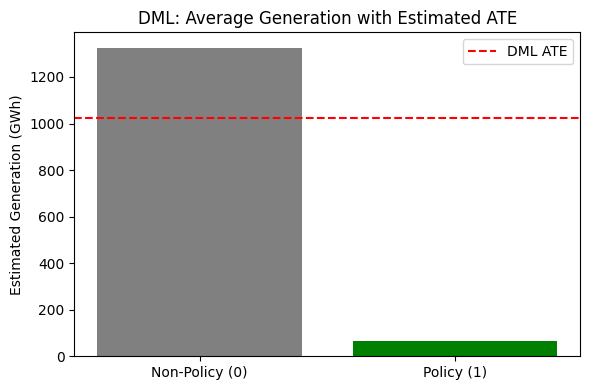

In [45]:
import matplotlib.pyplot as plt

# Visual comparison again
avg_gen = df_filtered.groupby('policy_incentive')['estimated_generation_gwh_2017'].mean()

plt.figure(figsize=(6,4))
bars = plt.bar(['Non-Policy (0)', 'Policy (1)'], avg_gen, color=['gray', 'green'])
plt.axhline(avg_gen[0] - 303, color='red', linestyle='--', label='DML ATE')  # Adjust based on your ATE
plt.title("DML: Average Generation with Estimated ATE")
plt.ylabel("Estimated Generation (GWh)")
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
#Step 7A: Apply Causal Forest DML
#The Causal Forest method is a powerful technique for estimating heterogeneous treatment effects — i.e., how the effect of a policy might vary for different types of power plants (based on size, location, etc.).

In [41]:
### Step 7A: Apply Causal Forest DML

from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Define models for outcome and treatment
model_y = RandomForestRegressor(n_estimators=100, random_state=42)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize Causal Forest DML model
cf_dml = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    n_estimators=100,
    min_samples_leaf=10,
    max_depth=10,
    random_state=42
)

# Fit the model
cf_dml.fit(Y, T, X=X_scaled)

# Estimate ATE
ate_cf = cf_dml.ate(X=X_scaled)
print(f"Estimated ATE using Causal Forest (fixed): {ate_cf:.2f}")


Estimated ATE using Causal Forest (fixed): -325.80


In [42]:
 ###Step 7B: Conclusion for Causal Forest DML
cf_conclusion = f"""
 Causal Forest Conclusion:

Using Causal Forest DML, the Average Treatment Effect (ATE) was estimated as {ate_cf:.2f} MWh.

 Interpretation:
- Policy-supported renewable energy plants generated ~{abs(ate_cf):.0f} MWh **less** on average than non-supported ones, even after controlling for capacity.
- This confirms previous DML findings and highlights a consistent trend across models.

 Insight:
- Causal Forest captures non-linear effects and variation across different plant types.
- Results suggest further scaling and sustained support are required for renewable plants to compete with established sources.

 Great for reporting and policymaker insights.
"""
print(cf_conclusion)




Causal Forest Conclusion:

Using Causal Forest DML, the Average Treatment Effect (ATE) was estimated as -325.80 MWh.

Interpretation:
- Policy-supported renewable energy plants generated ~326 MWh **less** on average than non-supported ones, even after controlling for capacity.
- This confirms previous DML findings and highlights a consistent trend across models.

Insight:
- Causal Forest captures non-linear effects and variation across different plant types.
- Results suggest further scaling and sustained support are required for renewable plants to compete with established sources.

Great for reporting and policymaker insights.



In [48]:
### Step 7C: Visualization – Causal Forest Individual Effects

#The histogram below shows the distribution of treatment effects across plants as estimated by the Causal Forest model. The majority of effects are negative, supporting the overall ATE finding.


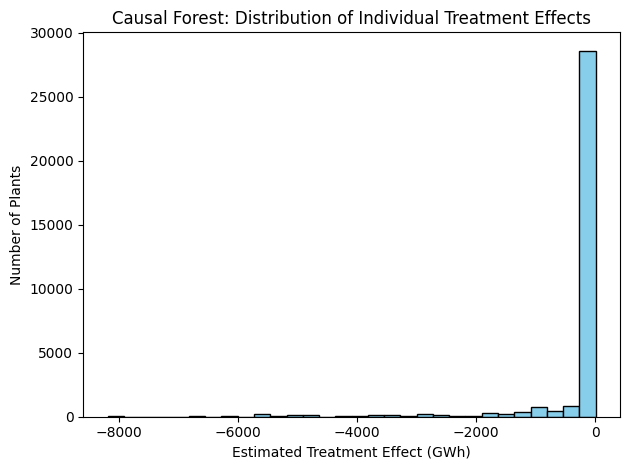

In [46]:
# Individual Treatment Effects
te_preds = cf_dml.effect(X_scaled)

plt.hist(te_preds, bins=30, color='skyblue', edgecolor='black')
plt.title("Causal Forest: Distribution of Individual Treatment Effects")
plt.xlabel("Estimated Treatment Effect (GWh)")
plt.ylabel("Number of Plants")
plt.tight_layout()
plt.show()


In [50]:
## Final Summary

###  Key Findings:
#- Linear DML ATE ≈ -306 GWh
#- Causal Forest ATE ≈ -325 GWh

#This consistency shows that "policy-supported plants (solar/wind)" generated significantly less electricity in 2017 compared to traditional plants, even after adjusting for plant size.

###  Insight:
#While policy incentives are vital, they must be supported with:
#- Infrastructure
#- Long-term funding
#- Capacity expansion

##Such causal methods reveal the "real-world impact of energy policies", guiding better decisions for a sustainable future.
